In [90]:
import numpy as np
from py_vollib.black_scholes import black_scholes as bs
import matplotlib.pyplot as plt

from QuantPy's Binomial Tree Option Pricing videos \
https://www.youtube.com/@QuantPy

# European Option

In [132]:
# Parameters, European Option
S0 = 100      # inital stock price
K = 100       # strike price
T = 1         # time to maturity in years
r = 0.06      # annual risk-free rate
N = 3         # number of time steps
u = 1.1       # up-factor in binomial models
d = 1/u       # down-factor, ensuring recombining tree
# recombining tree: underlying asset move (u,d) = (d,u), 1.1*(1/1.1) = (1/1.1)*1.1 = 1
opttype = 'C' # option type 'C' or 'P'

In [133]:
# recombining tree
# u: +10%
# d: -9.09%
print(f'S_u = {S0 * u}')
print(f'S_d = {S0 * d}')

print(f'S_ud = {S0 * u*d}')
print(f'S_du = {S0 * d*u}')

print(f'u% = {(u-1)*100}')
print(f'd% = {(d-1)*100}')

S_u = 110.00000000000001
S_d = 90.9090909090909
S_ud = 100.00000000000001
S_du = 100.0
u% = 10.000000000000009
d% = -9.090909090909093


In [134]:
dt = T/N
# single tree period in years
dt

0.3333333333333333

In [135]:
# risk-neutral probability to discount option payoff
pi = (np.exp(r*dt) - d) / (u - d)
pi

0.5820070191877681

In [136]:
S_T = np.zeros(N+1)
# defined bottom of the tree at maturity, only consist of down moves
S_T[0] = S0*(d**N)

In [137]:
# defining nodes above the bottom node at maturity, using zig-zag move up
for j in range(1, N+1):
    S_T[j] = S_T[j-1]*u/d
S_T

array([ 75.13148009,  90.90909091, 110.        , 133.1       ])

In [138]:
C_T = np.zeros(N+1)
# apply call rule to get payoff at maturity
for j in range(0,N+1):
    C_T[j] = max(0, S_T[j]-K)

print('call payoff at maturity', C_T, '\n')
for i in np.arange(N,0,-1):
    for j in range(0,i):
        print(f'time period {i}, node {j}')
        print(f'  * up-node: {C_T[j]}')
        print(f'  * down-node: {C_T[j+1]}')
        C_T[j] = np.exp(-r*dt) * ( pi*C_T[j+1] + (1-pi)*C_T[j] )
        print(f'  * base-node: {C_T[j]}')
    print('\n')
C_T

call payoff at maturity [ 0.   0.  10.  33.1] 

time period 3, node 0
  * up-node: 0.0
  * down-node: 0.0
  * base-node: 0.0
time period 3, node 1
  * up-node: 0.0
  * down-node: 10.0
  * base-node: 5.7048250806306955
time period 3, node 2
  * up-node: 10.0
  * down-node: 33.10000000000002
  * base-node: 22.980132669324473


time period 2, node 0
  * up-node: 0.0
  * down-node: 5.7048250806306955
  * base-node: 3.254502920059302
time period 2, node 1
  * up-node: 5.7048250806306955
  * down-node: 22.980132669324473
  * base-node: 15.447122776240315


time period 1, node 0
  * up-node: 3.254502920059302
  * down-node: 15.447122776240315
  * base-node: 10.145735799928817




array([10.1457358 , 15.44712278, 22.98013267, 33.1       ])

In [139]:
# vectorized version
S_T = S0 * d**(np.arange(N,-1,-1)) * u**(np.arange(0,N+1,1))
S_T

array([ 75.13148009,  90.90909091, 110.        , 133.1       ])

In [140]:
# map call rule
C_T = np.maximum(S_T - K, np.zeros(N+1))
print(f'call payoff: {C_T} \n')

for i in np.arange(N,0,-1):
    print(f'time period {i}')
    print(f'  * up-nodes: {C_T[1:i+1]}')
    print(f'  * down-nodes: {C_T[0:i]}')
    C_T = np.exp(-r*dt) * ( pi*C_T[1:i+1] + (1-pi)*C_T[0:i] )
    print(f'  * base-nodes: {C_T}')
    print('\n')
C_T

call payoff: [ 0.   0.  10.  33.1] 

time period 3
  * up-nodes: [ 0.  10.  33.1]
  * down-nodes: [ 0.  0. 10.]
  * base-nodes: [ 0.          5.70482508 22.98013267]


time period 2
  * up-nodes: [ 5.70482508 22.98013267]
  * down-nodes: [0.         5.70482508]
  * base-nodes: [ 3.25450292 15.44712278]


time period 1
  * up-nodes: [15.44712278]
  * down-nodes: [3.25450292]
  * base-nodes: [10.1457358]




array([10.1457358])

In [141]:
def binomial_tree_slow(S0,K,T,r,N,u,d,opttype='C',pi=None,method=None,dxu=None,dxd=None,pu=None,pd=None):
    # precompute constants
    # time steps for each single binomial tree
    dt = T/N
    # risk-neutral probability
    if pi == None:
        pi = (np.exp(r*dt) - d) / (u - d)
    
    # initialize asset prices at maturity - Time step N
    # there will be number of time steps + 1 branches at the end of the binomial tree
    S_T = np.zeros(N+1)
    if method == None:    
        # starting from the bottom only down moves tree, moving zig-zag up the node to compute maturity values
        S_T[0] = S0*(d**N)
        for j in range(1, N+1):
            S_T[j] = S_T[j-1]*u/d
    else:
        # assumes log asset pricing
        S_T[0] = S0*np.exp(N*dxd)
        for j in range(1, N+1):
            S_T[j] = S_T[j-1]*np.exp(dxu - dxd)
        
        
    # initialize option values at maturity
    V_T = np.zeros(N+1)
    for j in range(0,N+1):
        if opttype == 'C':
            V_T[j] = max(0, S_T[j]-K)
        elif opttype == 'P':
            V_T[j] = max(0, K - S_T[j])

    # step backwards through tree
    # each time period i
    for i in np.arange(N,0,-1):
        # number of nodes at each time period
        for j in range(0,i):
            if method == None: 
                V_T[j] = np.exp(-r*dt) * ( pi*V_T[j+1] + (1-pi)*V_T[j] )
            else:    
                V_T[j] = np.exp(-r*dt) * ( pu*V_T[j+1] + pd*V_T[j] )

    return V_T[0]

In [142]:
# vectorized tree
def binomial_tree_fast(S0,K,T,r,N,u,d,opttype='C',pi=None,method=None,dxu=None,dxd=None,pu=None,pd=None):
    # precompute constants
    # time steps for each single binomial tree
    dt = T/N
    # risk-neutral probability
    if pi == None:
        pi = (np.exp(r*dt) - d) / (u - d)
    
    if method == None:
        # initialize asset prices at maturity - Time step N
        S_T = S0 * d**(np.arange(N,-1,-1)) * u**(np.arange(0,N+1,1))
    else:
        S_T = S0*np.exp(np.arange(N,-1,-1)*dxd) * np.exp(np.arange(0,N+1,1)*dxu)
    
    if opttype == 'C':
        # initialize option values at maturity
        V_T = np.maximum(S_T - K, np.zeros(N+1))
    elif opttype == 'P':
        V_T = np.maximum(K - S_T, np.zeros(N+1))

    # step backwards through tree
    # each time period i
    for i in np.arange(N,0,-1):
        if method == None:
            V_T = np.exp(-r*dt) * ( pi*V_T[1:i+1] + (1-pi)*V_T[0:i] )
        else:
            V_T = np.exp(-r*dt) * ( pu*V_T[1:i+1] + pd*V_T[0:i] )

    return V_T[0]

In [143]:
binomial_tree_slow(S0,K,T,r,N,u,d,opttype='C'), \
binomial_tree_fast(S0,K,T,r,N,u,d,opttype='C')

(10.145735799928817, 10.145735799928826)

In [144]:
binomial_tree_slow(S0,K,T,r,N,u,d,opttype='P'), \
binomial_tree_fast(S0,K,T,r,N,u,d,opttype='P')

(4.322189158353709, 4.322189158353709)

# American Option

In [145]:
# Parameters, European Option
S0 = 100      # inital stock price
K = 100       # strike price
T = 1         # time to maturity in years
r = 0.06      # annual risk-free rate
N = 3         # number of time steps
u = 1.1       # up-factor in binomial models
d = 1/u       # down-factor, ensuring recombining tree
# recombining tree: underlying asset move (u,d) = (d,u), 1.1*(1/1.1) = (1/1.1)*1.1 = 1
opttype = 'P' # option type 'C' or 'P'

In [146]:
dt = T/N
pi = (np.exp(r*dt) - d) / (u - d)

In [147]:
S_T = np.zeros(N+1)
for j in range(0,N+1):
    S_T[j] = S0 * (u**j) * (d**(N-j))
# underlying prices at maturity just like European option

# put payoff at maturity
V_T = np.zeros(N+1)
for j in range(0,N+1):
    if opttype == 'P':
        V_T[j] = max(0, K - S_T[j])

print('underlying prices at maturity', S_T)
print('put payoff at maturity', V_T, '\n')

for i in np.arange(N-1,-1,-1):
    for j in range(0,i+1):
        print(f'time period {i}, node {j}')
        S_T = S0 * (u**j) * (d**(i-j))
        print(f'  * underlying price: {S_T}')
        print(f'  * up-node: {V_T[j]}')
        print(f'  * down-node: {V_T[j+1]}')
        V_T[j] = np.exp(-r*dt) * ( pi*V_T[j+1] + (1-pi)*V_T[j] )
        print(f'  * base-node, before applying put rule: {V_T[j]}')
        V_T[j] = max(V_T[j], K - S_T)
        print(f'  * base-node, after applying put rule: {V_T[j]}')
    print('\n')
V_T

underlying prices at maturity [ 75.13148009  90.90909091 110.         133.1       ]
put payoff at maturity [24.86851991  9.09090909  0.          0.        ] 

time period 2, node 0
  * underlying price: 82.64462809917354
  * up-node: 24.868519909842234
  * down-node: 9.090909090909093
  * base-node, before applying put rule: 15.37523923150199
  * base-node, after applying put rule: 17.355371900826455
time period 2, node 1
  * underlying price: 100.00000000000001
  * up-node: 9.090909090909093
  * down-node: 0.0
  * base-node, before applying put rule: 3.724692411306235
  * base-node, after applying put rule: 3.724692411306235
time period 2, node 2
  * underlying price: 121.00000000000001
  * up-node: 0.0
  * down-node: 0.0
  * base-node, before applying put rule: 0.0
  * base-node, after applying put rule: 0.0


time period 1, node 0
  * underlying price: 90.9090909090909
  * up-node: 17.355371900826455
  * down-node: 3.724692411306235
  * base-node, before applying put rule: 9.2356482

array([4.65458875, 1.52606669, 0.        , 0.        ])

In [148]:
# vectorized version
S_T = S0 * d**(np.arange(N,-1,-1)) * u**(np.arange(0,N+1,1))
V_T = np.maximum(0, K - S_T)
print('underlying prices at maturity', S_T)
print('put payoff at maturity', V_T, '\n')

for i in np.arange(N-1,-1,-1):
    print(f'time period {i}')
    S_T = S0 * d**(np.arange(i,-1,-1)) * u**(np.arange(0,i+1,1))
    print(f'  * up-nodes: {V_T[1:i+2]}')
    print(f'  * down-nodes: {V_T[0:i+1]}')
    V_T[:i+1] = np.exp(-r*dt) * ( pi*V_T[1:i+2] + (1-pi)*V_T[0:i+1] )
    print(f'  * base-nodes, before put rule: {V_T[:i+1]}')
    V_T = V_T[:-1]
    print(f'  * put rule payoffs: {K - S_T}')
    V_T = np.maximum(V_T, K - S_T)
    print(f'  * base-nodes, after put rule: {V_T}')

underlying prices at maturity [ 75.13148009  90.90909091 110.         133.1       ]
put payoff at maturity [24.86851991  9.09090909  0.          0.        ] 

time period 2
  * up-nodes: [9.09090909 0.         0.        ]
  * down-nodes: [24.86851991  9.09090909  0.        ]
  * base-nodes, before put rule: [15.37523923  3.72469241  0.        ]
  * put rule payoffs: [ 17.3553719   0.        -21.       ]
  * base-nodes, after put rule: [17.3553719   3.72469241  0.        ]
time period 1
  * up-nodes: [3.72469241 0.        ]
  * down-nodes: [17.3553719   3.72469241]
  * base-nodes, before put rule: [9.23564829 1.52606669]
  * put rule payoffs: [  9.09090909 -10.        ]
  * base-nodes, after put rule: [9.23564829 1.52606669]
time period 0
  * up-nodes: [1.52606669]
  * down-nodes: [9.23564829]
  * base-nodes, before put rule: [4.65458875]
  * put rule payoffs: [0.]
  * base-nodes, after put rule: [4.65458875]


In [149]:
def american_slow_tree(S0,K,T,r,N,u,d,opttype='P',pi=None):
    # precompute values
    dt = T/N
    if pi == None:
        pi = (np.exp(r*dt) - d) / (u - d)
    
    # initialize stock prices at maturity
    S_T = np.zeros(N+1)
    for j in range(0,N+1):
        S_T[j] = S0 * (u**j) * (d**(N-j))
    
    # option payoff
    V_T = np.zeros(N+1)
    for j in range(0,N+1):
        if opttype == 'P':
            V_T[j] = max(0, K - S_T[j])
        elif opttype == 'C':
            V_T[j] = max(0, S_T[j] - K)
    
    # backward recursion through the tree
    for i in np.arange(N-1,-1,-1):
        for j in range(0,i+1):
            S_T = S0 * (u**j) * (d**(i-j))
            V_T[j] = np.exp(-r*dt) * ( pi*V_T[j+1] + (1-pi)*V_T[j] )
            if opttype == 'P':
                V_T[j] = max(V_T[j], K - S_T)
            elif opttype == 'C':
                V_T[j] = max(V_T[j], S_T - K)
                
    return V_T[0]

In [150]:
# vectorized tree
def american_fast_tree(S0,K,T,r,N,u,d,opttype='P',pi=None):
    # precompute values
    dt = T/N
    if pi == None:
        pi = (np.exp(r*dt) - d) / (u - d)
    
    # initialize stock prices at maturity
    S_T = S0 * d**(np.arange(N,-1,-1)) * u**(np.arange(0,N+1,1))
    
    # option payoff
    if opttype == 'P':
        V_T = np.maximum(0, K - S_T)
    elif opttype == 'C':
        V_T = np.maximum(0, S_T - K)
    
    # backward recursion through the tree
    for i in np.arange(N-1,-1,-1):
        S_T = S0 * d**(np.arange(i,-1,-1)) * u**(np.arange(0,i+1,1))
        V_T[:i+1] = np.exp(-r*dt) * ( pi*V_T[1:i+2] + (1-pi)*V_T[0:i+1] )
        V_T = V_T[:-1]
        if opttype == 'P':
            V_T = np.maximum(V_T, K - S_T)
        elif opttype == 'C':
            V_T = np.maximum(V_T, S_T - K)
                
    return V_T[0]

In [151]:
american_slow_tree(S0,K,T,r,N,u,d,opttype='P'), \
american_fast_tree(S0,K,T,r,N,u,d,opttype='P')

(4.654588754602527, 4.654588754602527)

In [152]:
american_slow_tree(S0,K,T,r,N,u,d,opttype='C'), \
american_fast_tree(S0,K,T,r,N,u,d,opttype='C')

(10.145735799928826, 10.145735799928826)

# Binomial Tree Parameters

In [153]:
# Parameters, European Option
S0 = 100      # inital stock price
K = 110       # strike price
T = 0.5       # time to maturity in years
r = 0.06      # annual risk-free rate
N = 100       # number of time steps
sigma = 0.3   # Annualized stock price volatility
# recombining tree: underlying asset move (u,d) = (d,u), 1.1*(1/1.1) = (1/1.1)*1.1 = 1
opttype = 'C' # option type 'C' or 'P'

In [154]:
# Cox, Ross and Rubinstein (CRR) Method
# = equal jump sizes up and down
def CRR_method(T,N,sigma):
    dt = T/N
    u = np.exp(sigma*np.sqrt(dt))
    # recombining tree
    d = 1/u
    return u,d

In [155]:
u,d = CRR_method(T,N,sigma)
print(u,d)
binomial_tree_slow(S0,K,T,r,N,u,d,opttype='C'), \
binomial_tree_fast(S0,K,T,r,N,u,d,opttype='C')

1.0214398028992784 0.9790102139759748


(5.77342630682585, 5.773426306825837)

In [156]:
# Jarrow and Rudd (JR) Method
# = equal risk-neutral probabilities
def JR_method(T,N,r,sigma):
    dt = T/N
    nu = r - 0.5*sigma**2
    u = np.exp(nu*dt + sigma*np.sqrt(dt))
    d = np.exp(nu*dt - sigma*np.sqrt(dt))
    pi = 0.5
    return u,d,pi

In [157]:
u,d,pi = JR_method(T,N,r,sigma)
print(u,d,pi)
binomial_tree_slow(S0,K,T,r,N,u,d,opttype='C',pi=pi), \
binomial_tree_fast(S0,K,T,r,N,u,d,opttype='C',pi=pi)

1.0215164137573671 0.979083642495558 0.5


(5.754089414567556, 5.754089414567574)

In [158]:
# Equal Probabilities (EQP) Method
# = choose equal risk-neutral probabilities, under log asset pricing tree
def EQP_method(T,N,r,sigma):
    dt = T/N
    nu = r - 0.5*sigma**2
    dxu = 0.5*nu*dt + 0.5*np.sqrt(4*sigma**2 * dt - 3*nu**2 * dt**2)
    dxd = 1.5*nu*dt - 0.5*np.sqrt(4*sigma**2 * dt - 3*nu**2 * dt**2)
    pu = 0.5
    pd = 1-pu
    return dxu,dxd,pu,pd


In [159]:
dxu,dxd,pu,pd = EQP_method(T,N,r,sigma)
print(dxu,dxd,pu,pd)
binomial_tree_slow(S0,K,T,r,N,u,d,opttype='C',
                   method='EQP',dxu=dxu,dxd=dxd,pu=pu,pd=pd), \
binomial_tree_fast(S0,K,T,r,N,u,d,opttype='C',
                   method='EQP',dxu=dxu,dxd=dxd,pu=pu,pd=pd)

0.021250603998472263 -0.021100603998472262 0.5 0.5


(5.7365844788666545, 5.736584478866665)

In [160]:
# Trigeorgis (TRG) Method
# = choose equal jump sizes, under log asset pricing tree
def TRG_method(T,N,r,sigma):
    dt = T/N
    nu = r - 0.5*sigma**2
    dxu = np.sqrt(sigma**2 * dt + nu**2 * dt**2)
    dxd = -dxu
    pu = 0.5 + 0.5*(nu*dt)/dxu
    pd = 1-pu
    return dxu,dxd,pu,pd

In [161]:
dxu,dxd,pu,pd = TRG_method(T,N,r,sigma)
print(dxu,dxd,pu,pd)
binomial_tree_slow(S0,K,T,r,N,u,d,opttype='C',
                   method='TRG',dxu=dxu,dxd=dxd,pu=pu,pd=pd), \
binomial_tree_fast(S0,K,T,r,N,u,d,opttype='C',
                   method='TRG',dxu=dxu,dxd=dxd,pu=pu,pd=pd)

0.02121333601770358 -0.02121333601770358 0.5017677559045265 0.4982322440954735


(5.773359020180677, 5.77335902018071)

### Greater Time Steps => continuous time, binomial pricing converges towards BSM pricing

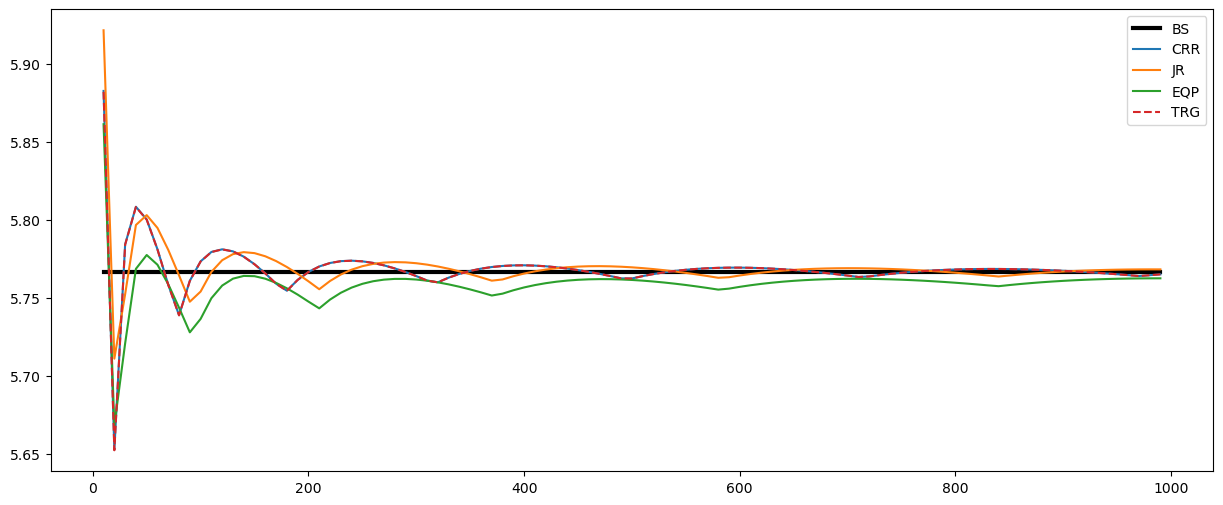

In [162]:
CRR, JR, EQP, TRG = [],[],[],[]

periods = range(10,1000,10)
for N in periods:
    u,d = CRR_method(T,N,sigma)
    CRR.append(binomial_tree_fast(S0,K,T,r,N,u,d,opttype='C'))
    u,d,pi = JR_method(T,N,r,sigma)
    JR.append(binomial_tree_fast(S0,K,T,r,N,u,d,opttype='C',pi=pi))
    dxu,dxd,pu,pd = EQP_method(T,N,r,sigma)
    EQP.append(binomial_tree_fast(S0,K,T,r,N,u,d,opttype='C',
                   method='EQP',dxu=dxu,dxd=dxd,pu=pu,pd=pd))
    dxu,dxd,pu,pd = TRG_method(T,N,r,sigma)
    TRG.append(binomial_tree_fast(S0,K,T,r,N,u,d,opttype='C',
                   method='TRG',dxu=dxu,dxd=dxd,pu=pu,pd=pd))

BS = [bs('c', S0, K, T, r, sigma) for i in periods]

plt.subplots(figsize=(15,6))
plt.plot(periods, BS, label='BS', linewidth=3, c='black')
plt.plot(periods, CRR, label='CRR')
plt.plot(periods, JR, label='JR')
plt.plot(periods, EQP, label='EQP')
plt.plot(periods, TRG, label='TRG', linestyle='--')
plt.legend();